# Neural Network Assignment
## Forest fires data
Predict the burnt area of forest fires with Neural Network

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier

2023-04-30 19:47:53.000843: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-30 19:47:55.361299: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-30 19:47:55.362450: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 19:47:59.609775: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [26]:
data = pd.read_csv('forestfires.csv')

### Data Description
- month:	month of the year: 'jan' to 'dec'
- day:	day of the week: 'mon' to 'sun'
- FFMC:	FFMC index from the FWI system: 18.7 to 96.20
- DMC:	DMC index from the FWI system: 1.1 to 291.3
- DC:	DC index from the FWI system: 7.9 to 860.6
- ISI:	ISI index from the FWI system: 0.0 to 56.10
- temp:	temperature in Celsius degrees: 2.2 to 33.30
- RH:	relative humidity in %: 15.0 to 100
- wind:	wind speed in km/h: 0.40 to 9.40
- rain:	outside rain in mm/m2 : 0.0 to 6.4
- size_category: 	the burned area of the forest (small,large)

In [27]:
data.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small


In [28]:
data.isna().sum().any()

False

In [29]:
data.duplicated().sum()

8

In [30]:
data.drop_duplicates(inplace=True)

In [ ]:
plt.pie(data, )

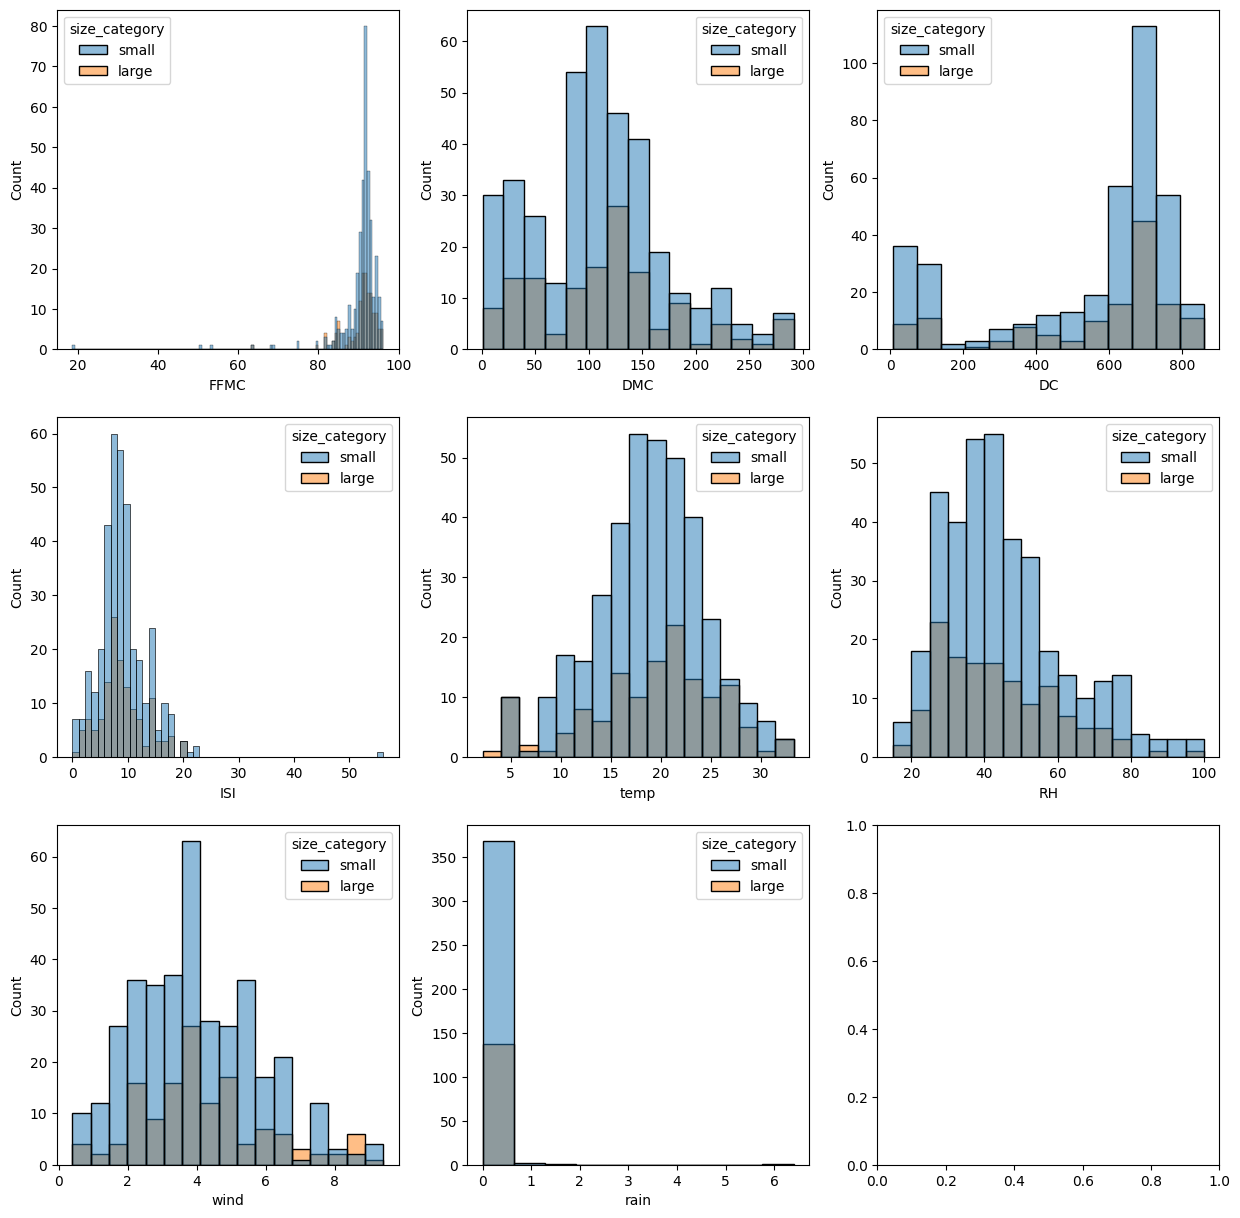

In [42]:
num_columns = ['FFMC','DMC','DC','ISI','temp','RH','wind','rain']

figs, axes = plt.subplots(nrows=3,ncols=3,figsize=(15,15))
for i in range(len(num_columns)):
    sns.histplot(data=data,x=num_columns[i],hue='size_category', ax=axes[i//3,i%3])

In [11]:
data.drop(['month','day','size_category'], axis=1, inplace=True)

Index(['month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind',
       'rain', 'area', 'dayfri', 'daymon', 'daysat', 'daysun', 'daythu',
       'daytue', 'daywed', 'monthapr', 'monthaug', 'monthdec', 'monthfeb',
       'monthjan', 'monthjul', 'monthjun', 'monthmar', 'monthmay', 'monthnov',
       'monthoct', 'monthsep', 'size_category'],
      dtype='object')

In [13]:
x = data.drop('size_category', axis=1)
y = data['size_category'].replace({'small':0,'large':1})

In [14]:
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

In [15]:
x.shape

(509, 28)

In [16]:
def create_model(hidden_units=42, optimizer='adam',activation='relu',dropout_rate=0.0):
    model = Sequential([
        Dense(hidden_units, input_dim=28, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation=activation)
    ])
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [17]:
param_grid = {'batch_size':[20,40,60,80,100], 
              'epochs':[10,20,30,40,50]}

In [18]:
#from scikeras.wrappers import KerasClassifier
#model = KerasClassifier(build_fn=create_model, verbose=0)
model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, verbose=0)

/tmp/ipykernel_15767/1681483163.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, verbose=0)


In [19]:
model.get_params().keys()

dict_keys(['verbose', 'build_fn'])

In [20]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=KFold(), verbose=10)
grid_result = grid.fit(x,y)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5; 1/25] START batch_size=20, epochs=10...................................
[CV 1/5; 1/25] END ....batch_size=20, epochs=10;, score=0.000 total time=   4.3s
[CV 2/5; 1/25] START batch_size=20, epochs=10...................................
[CV 2/5; 1/25] END ....batch_size=20, epochs=10;, score=0.000 total time=   1.2s
[CV 3/5; 1/25] START batch_size=20, epochs=10...................................
[CV 3/5; 1/25] END ....batch_size=20, epochs=10;, score=0.049 total time=   1.0s
[CV 4/5; 1/25] START batch_size=20, epochs=10...................................
[CV 4/5; 1/25] END ....batch_size=20, epochs=10;, score=0.010 total time=   1.1s
[CV 5/5; 1/25] START batch_size=20, epochs=10...................................
[CV 5/5; 1/25] END ....batch_size=20, epochs=10;, score=0.010 total time=   1.2s
[CV 1/5; 2/25] START batch_size=20, epochs=20...................................
[CV 1/5; 2/25] END ....batch_size=20, epochs=20

In [21]:
print('Best: {}, using {}'.format(grid_result.best_score_, grid_result.best_params_))

Best: 0.1947777159512043, using {'batch_size': 100, 'epochs': 10}


<Axes: xlabel='param_epochs', ylabel='param_batch_size'>

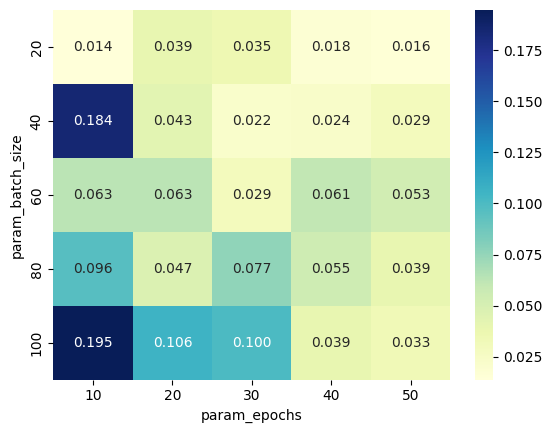

In [22]:
grid_result_df = pd.DataFrame(grid_result.cv_results_)
mean_scores = grid_result_df.pivot_table(values='mean_test_score', index='param_batch_size', columns='param_epochs')
sns.heatmap(mean_scores, cmap="YlGnBu", annot=True, fmt=".3f")

<Axes: xlabel='param_epochs', ylabel='param_batch_size'>

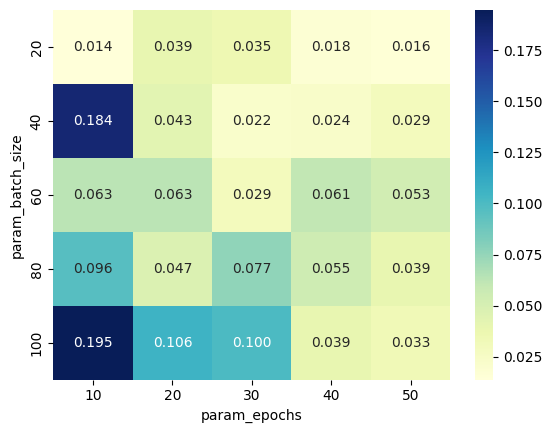

In [23]:
grid_result_df = pd.DataFrame(grid_result.cv_results_)
mean_scores = grid_result_df.pivot_table(values='mean_test_score', index='param_batch_size', columns='param_epochs')
sns.heatmap(mean_scores, cmap="YlGnBu", annot=True, fmt=".3f")

In [24]:
model = create_model(activation='tanh',dropout_rate=0.1,optimizer='adam')
history = model.fit(x,y,validation_split=0.2,epochs=10,batch_size=94)

Epoch 1/10
5/5 [==============================] - 1s 169ms/step - loss: 39.9704 - accuracy: 0.3071 - val_loss: 51.2304 - val_accuracy: 0.1373
Epoch 2/10
5/5 [==============================] - 0s 9ms/step - loss: 29.0457 - accuracy: 0.2899 - val_loss: 34.1896 - val_accuracy: 0.1078
Epoch 3/10
5/5 [==============================] - 0s 14ms/step - loss: 17.4905 - accuracy: 0.2482 - val_loss: 15.4095 - val_accuracy: 0.1078
Epoch 4/10
5/5 [==============================] - 0s 14ms/step - loss: 21.4622 - accuracy: 0.2236 - val_loss: 9.8660 - val_accuracy: 0.0980
Epoch 5/10
5/5 [==============================] - 0s 9ms/step - loss: 5.3311 - accuracy: 0.2236 - val_loss: 6.6526 - val_accuracy: 0.0686
Epoch 6/10
5/5 [==============================] - 0s 13ms/step - loss: -5.2872 - accuracy: 0.2088 - val_loss: 3.5578 - val_accuracy: 0.0686
Epoch 7/10
5/5 [==============================] - 0s 9ms/step - loss: -6.9844 - accuracy: 0.2015 - val_loss: 0.9624 - val_accuracy: 0.0686
Epoch 8/10
5/5 [====